In [40]:
import pandas as pd
from sklearn.impute import SimpleImputer

import matplotlib.pyplot as plt
import random
import seaborn as sns
import numpy as np

from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import classification_report

Будем учиться классифицировать жанры музыки, полузуюсь не аудио дорожками, а уже осмысленными признаками (правда, не все из них имеют понятные названия). Сами данные можно найти [здесь](https://www.kaggle.com/purumalgi/music-genre-classification). Будем использовать файл `train.csv`. Нашей задачей будет предсказание переменной `Class` (жанр песни) при помощи деревьев решений. Можно попробовать также другие методы классификации, которые мы прошли, и сравнить результаты. При обучении всех моделей не забывайте про разделение на тренировку и тест (или кросс валидацию [ссылка](https://www.youtube.com/watch?v=fSytzGwwBVw)).

### Задание 1. EDA (10 баллов)

Как обычно, начнем с того, что посмотрим на наши данные: типы переменных, пропущенные значения, баланс классов и все такое. Ваш ход:

In [2]:
data = pd.read_csv("data/train.csv")
data.head()

Artist Name                             Track Name  Popularity  \
0             Bruno Mars  That's What I Like (feat. Gucci Mane)        60.0   
1                 Boston                           Hitch a Ride        54.0   
2          The Raincoats                     No Side to Fall In        35.0   
3                   Deno             Lingo (feat. J.I & Chunkz)        66.0   
4  Red Hot Chili Peppers      Nobody Weird Like Me - Remastered        53.0   

   danceability  energy   key  loudness  mode  speechiness  acousticness  \
0         0.854   0.564   1.0    -4.964     1       0.0485      0.017100   
1         0.382   0.814   3.0    -7.230     1       0.0406      0.001100   
2         0.434   0.614   6.0    -8.334     1       0.0525      0.486000   
3         0.853   0.597  10.0    -6.528     0       0.0555      0.021200   
4         0.167   0.975   2.0    -4.279     1       0.2160      0.000169   

   instrumentalness  liveness  valence    tempo  duration_in min/ms  \
0               NaN    0.0849   0.8990  134.071            234596.0   
1          0.004010    0.1010   0.5690  116.454            251733.0   
2          0.000196    0.3940   0.7870  147.681            109667.0   
3               NaN    0.1220   0.5690  107.033            173968.0   
4          0.016100    0.1720   0.0918  199.060            229960.0   

   time_signature  Class  
0               4      5  
1               4     10  
2               4      6  
3               4      5  
4               4     10

In [3]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 17996 entries, 0 to 17995
Data columns (total 17 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   Artist Name         17996 non-null  object 
 1   Track Name          17996 non-null  object 
 2   Popularity          17568 non-null  float64
 3   danceability        17996 non-null  float64
 4   energy              17996 non-null  float64
 5   key                 15982 non-null  float64
 6   loudness            17996 non-null  float64
 7   mode                17996 non-null  int64  
 8   speechiness         17996 non-null  float64
 9   acousticness        17996 non-null  float64
 10  instrumentalness    13619 non-null  float64
 11  liveness            17996 non-null  float64
 12  valence             17996 non-null  float64
 13  tempo               17996 non-null  float64
 14  duration_in min/ms  17996 non-null  float64
 15  time_signature      17996 non-null  int64  
 16  Clas

In [4]:
categorical_features = ['key', 'mode', 'time_signature']
num_features = ['Popularity', 'danceability', 'energy', 'loudness', 'speechiness',
       'acousticness', 'instrumentalness', 'liveness', 'valence', 'tempo',
       'duration_in min/ms']
def encode_categorical(df):
    df[categorical_features] = df[categorical_features].astype('category')
    return pd.get_dummies(df, columns=categorical_features, drop_first=True)

data_encoded = encode_categorical(data)

In [5]:
data_encoded.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 17996 entries, 0 to 17995
Data columns (total 28 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   Artist Name         17996 non-null  object 
 1   Track Name          17996 non-null  object 
 2   Popularity          17568 non-null  float64
 3   danceability        17996 non-null  float64
 4   energy              17996 non-null  float64
 5   loudness            17996 non-null  float64
 6   speechiness         17996 non-null  float64
 7   acousticness        17996 non-null  float64
 8   instrumentalness    13619 non-null  float64
 9   liveness            17996 non-null  float64
 10  valence             17996 non-null  float64
 11  tempo               17996 non-null  float64
 12  duration_in min/ms  17996 non-null  float64
 13  Class               17996 non-null  int64  
 14  key_2.0             17996 non-null  bool   
 15  key_3.0             17996 non-null  bool   
 16  key_

In [6]:
data_encoded.describe()

Popularity  danceability        energy      loudness   speechiness  \
count  17568.000000  17996.000000  17996.000000  17996.000000  17996.000000   
mean      44.512124      0.543433      0.662777     -7.910660      0.079707   
std       17.426928      0.166268      0.235373      4.049151      0.083576   
min        1.000000      0.059600      0.000020    -39.952000      0.022500   
25%       33.000000      0.432000      0.509000     -9.538000      0.034800   
50%       44.000000      0.545000      0.700000     -7.016000      0.047400   
75%       56.000000      0.659000      0.860000     -5.189000      0.083000   
max      100.000000      0.989000      1.000000      1.355000      0.955000   

       acousticness  instrumentalness      liveness       valence  \
count  17996.000000      13619.000000  17996.000000  17996.000000   
mean       0.247082          0.177562      0.196170      0.486208   
std        0.310632          0.304048      0.159212      0.240195   
min        0.000000          0.000001      0.011900      0.018300   
25%        0.004300          0.000089      0.097500      0.297000   
50%        0.081400          0.003910      0.129000      0.481000   
75%        0.434000          0.200000      0.258000      0.672000   
max        0.996000          0.996000      1.000000      0.986000   

              tempo  duration_in min/ms         Class  
count  17996.000000        1.799600e+04  17996.000000  
mean     122.623294        2.007445e+05      6.695821  
std       29.571527        1.119891e+05      3.206073  
min       30.557000        5.016500e-01      0.000000  
25%       99.620750        1.663370e+05      5.000000  
50%      120.065500        2.091600e+05      8.000000  
75%      141.969250        2.524900e+05     10.000000  
max      217.416000        1.477187e+06     10.000000

In [7]:
data_encoded.isna().sum()

Artist Name              0
Track Name               0
Popularity             428
danceability             0
energy                   0
loudness                 0
speechiness              0
acousticness             0
instrumentalness      4377
liveness                 0
valence                  0
tempo                    0
duration_in min/ms       0
Class                    0
key_2.0                  0
key_3.0                  0
key_4.0                  0
key_5.0                  0
key_6.0                  0
key_7.0                  0
key_8.0                  0
key_9.0                  0
key_10.0                 0
key_11.0                 0
mode_1                   0
time_signature_3         0
time_signature_4         0
time_signature_5         0
dtype: int64

Много пропущенных по популярности и инструменталу

In [8]:
data_encoded.Class.value_counts()
# выборка несбалансирована

Class
10    4949
6     2587
9     2524
8     1854
5     1447
1     1373
2     1272
0      625
7      576
3      402
4      387
Name: count, dtype: int64

<Axes: xlabel='Class', ylabel='Count'>

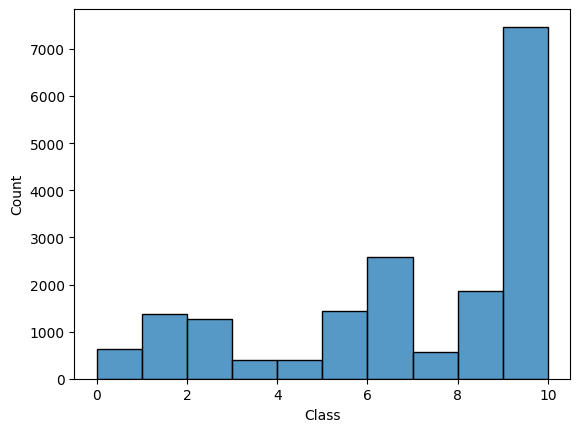

In [9]:
sns.histplot(data_encoded['Class'], bins=10)

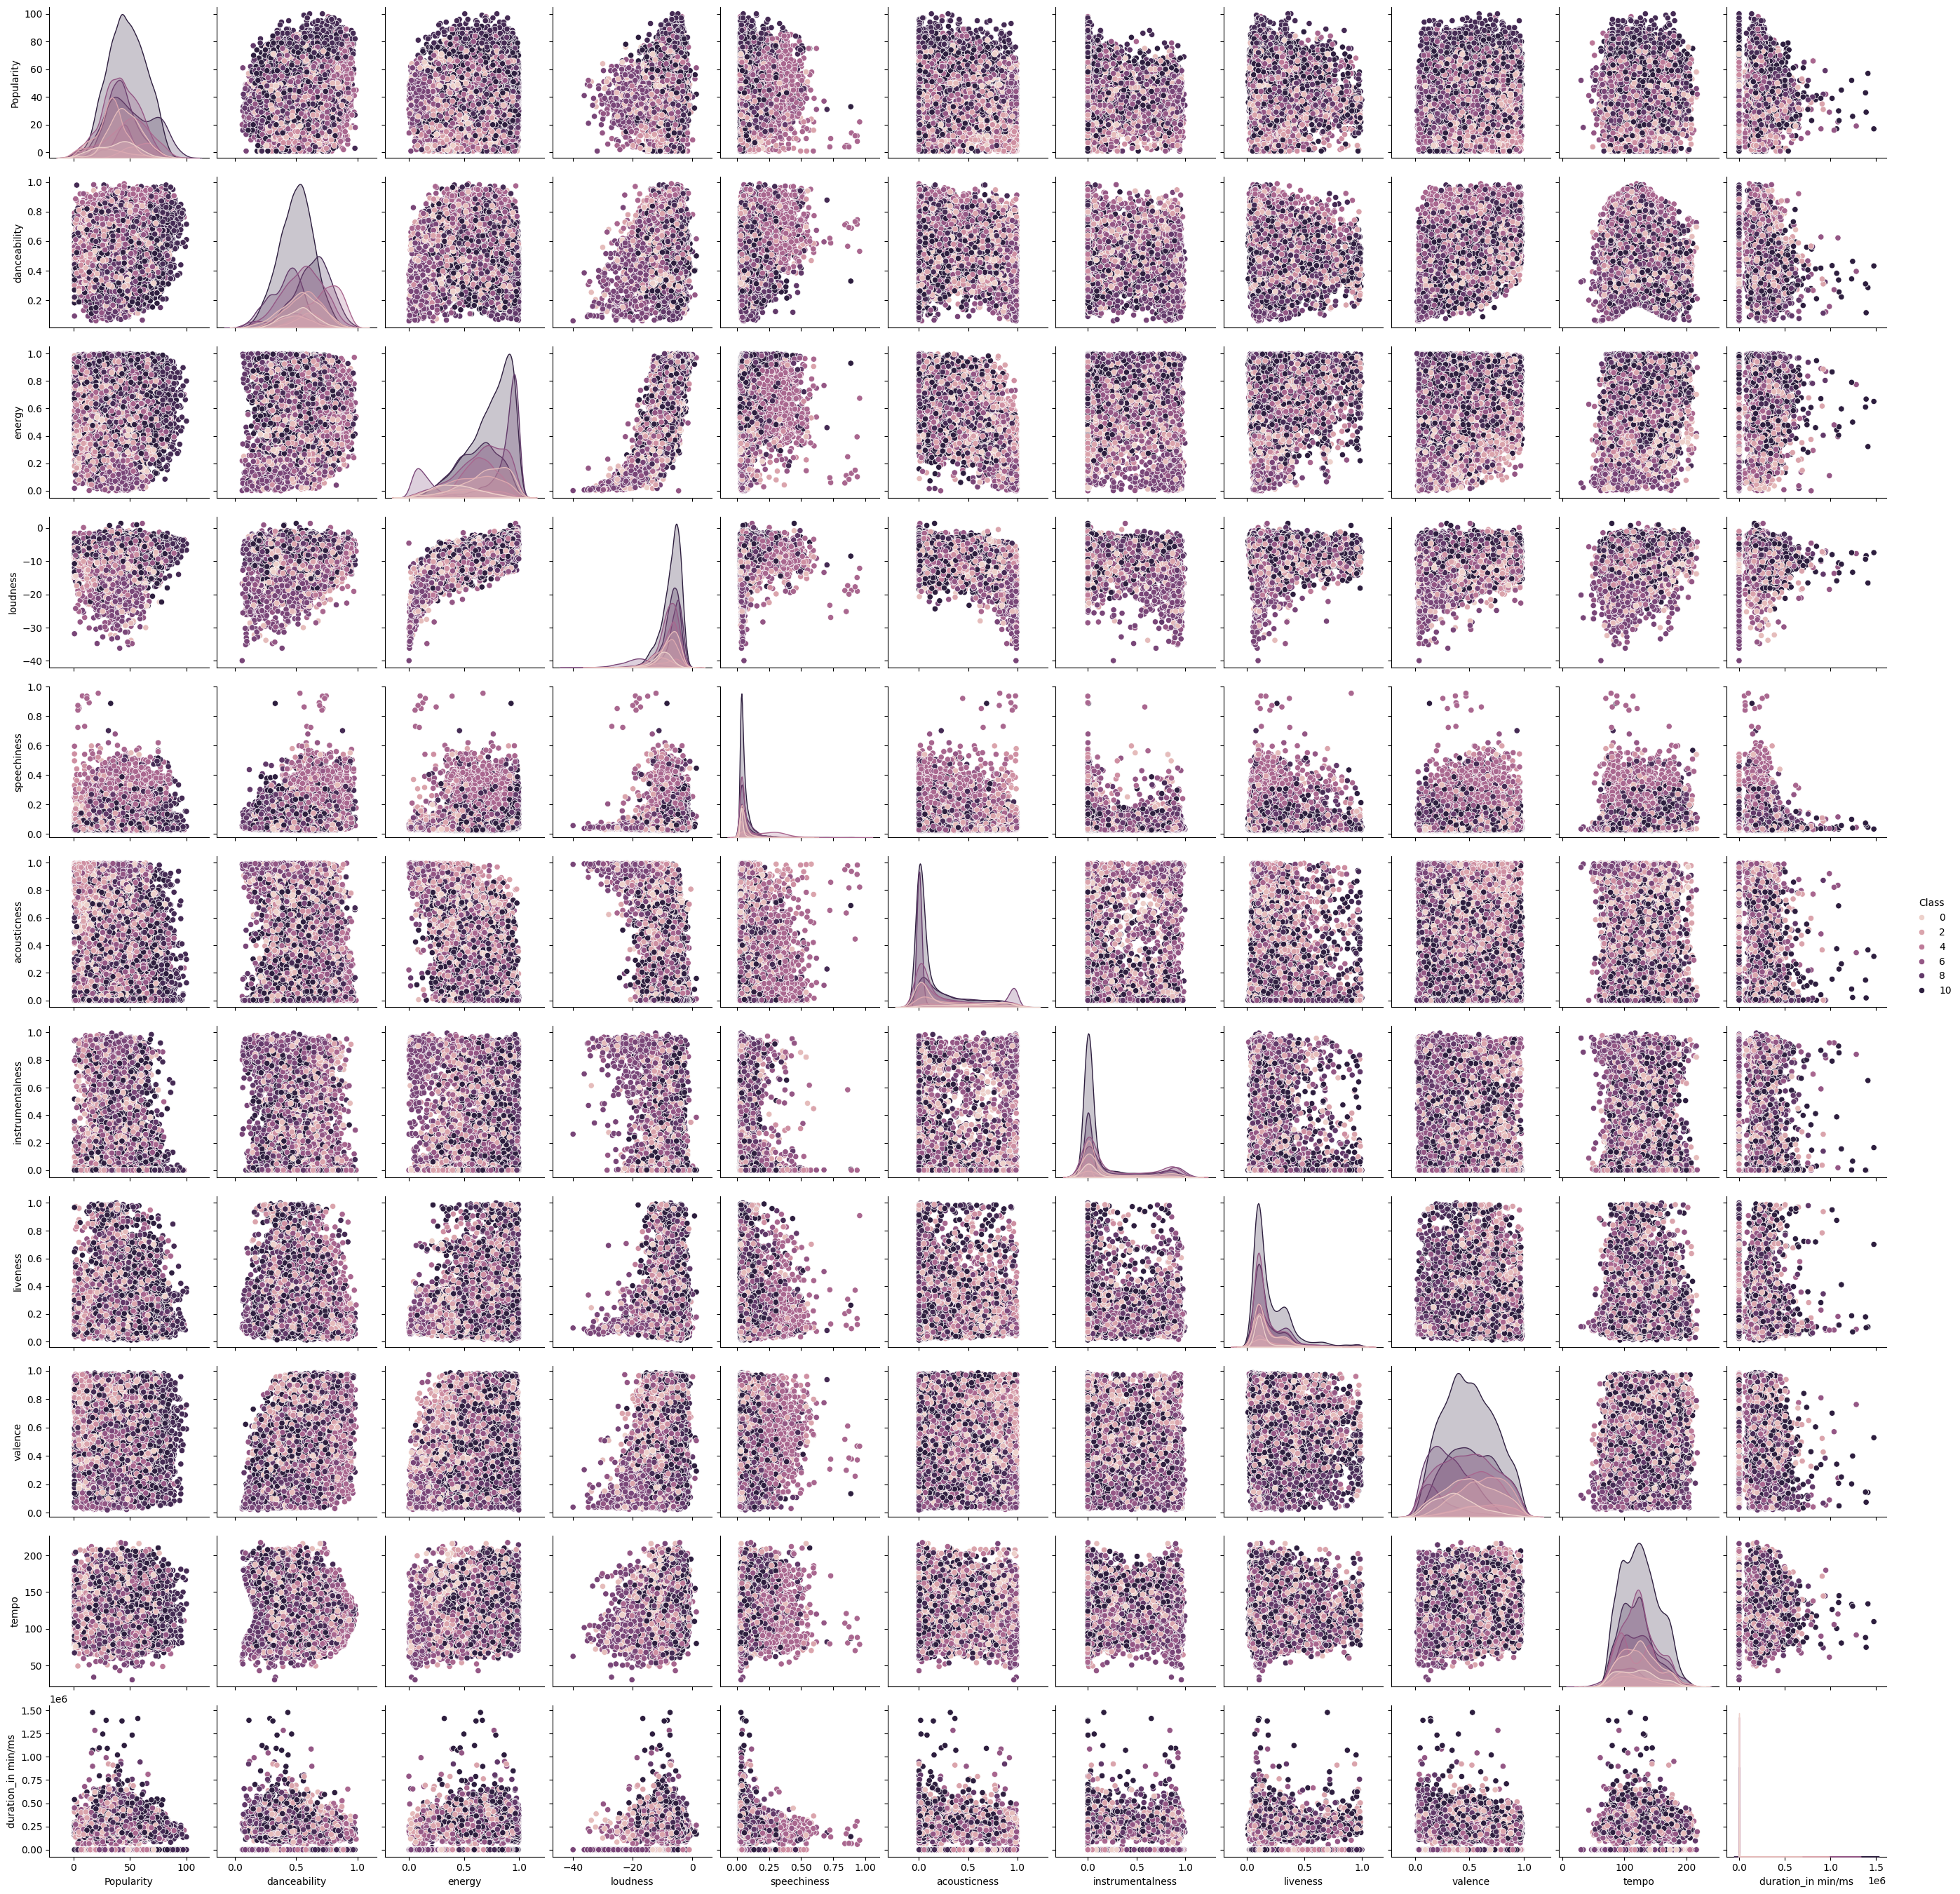

In [10]:
pairplot_feat = ['Popularity', 'danceability', 'energy', 'loudness', 'speechiness',
       'acousticness', 'instrumentalness', 'liveness', 'valence', 'tempo',
       'duration_in min/ms', 'Class']
sns.pairplot(data_encoded[pairplot_feat], hue='Class')

<Axes: >

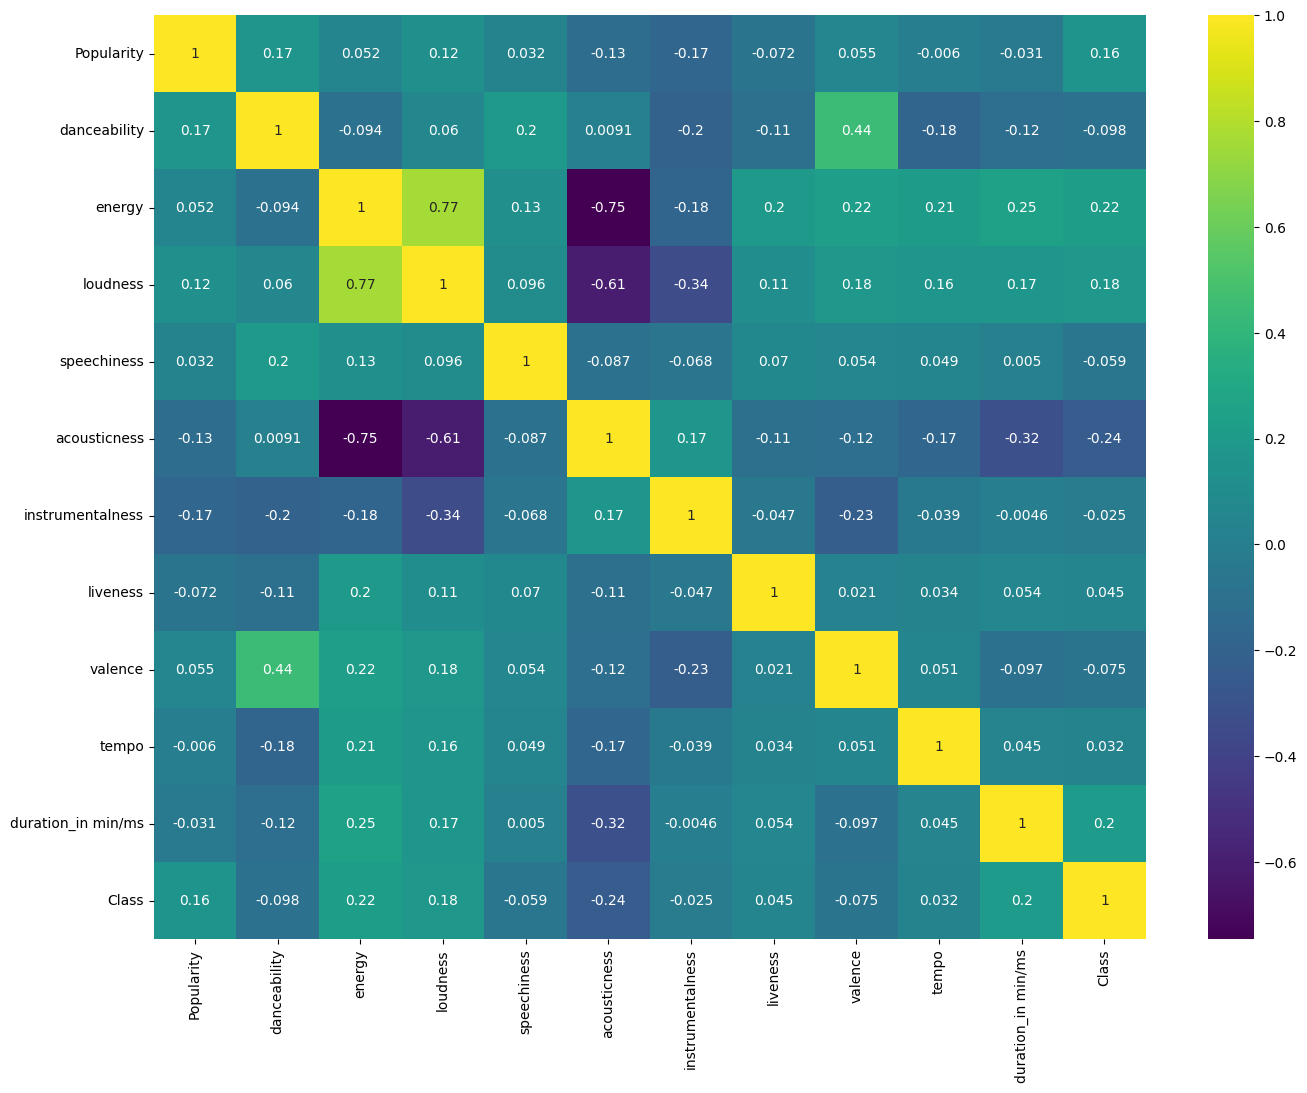

In [11]:
corr_matrix = data_encoded[pairplot_feat].corr()
fig, ax = plt.subplots(figsize=(16,12))

sns.heatmap(corr_matrix, annot=True,ax=ax, cmap='viridis')

Возможно можно будет заменить энергию и акустику друг на друга, либо громкость и акустику (эти пары хорошо скоррелированы). Но с другой стороны, тут классификация не с помощью регрессии, а с помощью дерева, тут необязательно удалять скореллированные переменные

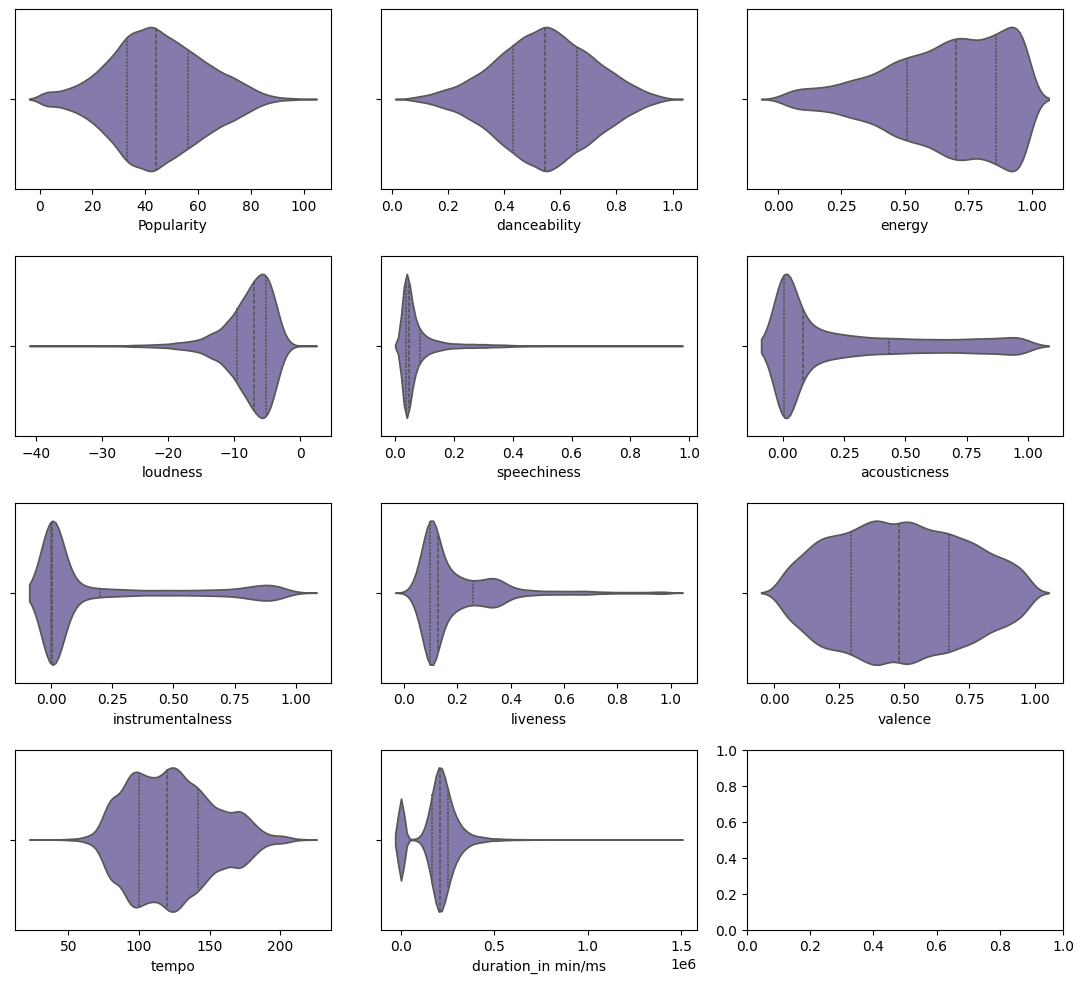

In [12]:
# распределение данных
fig, axes = plt.subplots(nrows=4, ncols=3, figsize=(11, 10))

for i in range(data_encoded[num_features].columns.size):
    feature = data_encoded[num_features].columns[i]
    sns.set(style="darkgrid")
    sns.violinplot(x=data_encoded[feature], ax=axes[i//3, i%3], inner="quartile", color='m')

plt.tight_layout()
plt.show();

Замена пропущенных медианами у колонок инструментов и популярности

In [18]:
data_encoded.columns

Index(['Artist Name', 'Track Name', 'Popularity', 'danceability', 'energy',
       'loudness', 'speechiness', 'acousticness', 'instrumentalness',
       'liveness', 'valence', 'tempo', 'duration_in min/ms', 'Class',
       'key_2.0', 'key_3.0', 'key_4.0', 'key_5.0', 'key_6.0', 'key_7.0',
       'key_8.0', 'key_9.0', 'key_10.0', 'key_11.0', 'mode_1',
       'time_signature_3', 'time_signature_4', 'time_signature_5'],
      dtype='object')

In [17]:
miss_cols = ['Popularity', 'instrumentalness']
num_imputer = SimpleImputer(strategy='median')
processed_df = data_encoded.copy()

processed_df.loc[ : , miss_cols] = num_imputer.fit_transform(processed_df.loc[ : , miss_cols])

processed_df.isna().sum()


Artist Name           0
Track Name            0
Popularity            0
danceability          0
energy                0
loudness              0
speechiness           0
acousticness          0
instrumentalness      0
liveness              0
valence               0
tempo                 0
duration_in min/ms    0
Class                 0
key_2.0               0
key_3.0               0
key_4.0               0
key_5.0               0
key_6.0               0
key_7.0               0
key_8.0               0
key_9.0               0
key_10.0              0
key_11.0              0
mode_1                0
time_signature_3      0
time_signature_4      0
time_signature_5      0
dtype: int64

In [34]:
processed_df.pop('Artist Name')
processed_df.pop('Track Name')

0        That's What I Like (feat. Gucci Mane)
1                                 Hitch a Ride
2                           No Side to Fall In
3                   Lingo (feat. J.I & Chunkz)
4            Nobody Weird Like Me - Remastered
                         ...                  
17991                                Find Home
17992                                 All Gone
17993                             Peine perdue
17994                           Salomon's Gate
17995                       Broken Boy Soldier
Name: Track Name, Length: 17996, dtype: object

### Задание 2. Обучение дерева решений (10 баллов)

Предобработайте признаки так, чтобы их можно было подать в модель дерева решений и обучите ее, постарайтесь подобрать оптимальные гиперпараметры, которые вам известны. Постарайтесь также обосновать выбор метрики в данном случае. При подборе гиперпараметров может помочь `GridSearchCV` [ссылка](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.GridSearchCV.html).

In [35]:
SEED = 111
random.seed(SEED)
np.random.seed(SEED)

In [36]:
X = processed_df.copy()
y = pd.DataFrame(X.pop('Class'))
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=SEED, test_size=0.2)

In [37]:
X.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 17996 entries, 0 to 17995
Data columns (total 25 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   Popularity          17996 non-null  float64
 1   danceability        17996 non-null  float64
 2   energy              17996 non-null  float64
 3   loudness            17996 non-null  float64
 4   speechiness         17996 non-null  float64
 5   acousticness        17996 non-null  float64
 6   instrumentalness    17996 non-null  float64
 7   liveness            17996 non-null  float64
 8   valence             17996 non-null  float64
 9   tempo               17996 non-null  float64
 10  duration_in min/ms  17996 non-null  float64
 11  key_2.0             17996 non-null  bool   
 12  key_3.0             17996 non-null  bool   
 13  key_4.0             17996 non-null  bool   
 14  key_5.0             17996 non-null  bool   
 15  key_6.0             17996 non-null  bool   
 16  key_

Использовать метрики precision, recall, f1 - потому что данные несбалансированные

In [43]:
def train_decision_tree(X, y, folds = 5):
    # параметры
    param_grid = {
        'clf__max_depth': [5, 8, 10, 20, 30],
        'clf__min_samples_split': [2, 5, 10],
        'clf__min_samples_leaf': [1, 2, 4]
    }

    # pipe
    my_pipe = Pipeline([('scaler', StandardScaler()),     
    ('clf', DecisionTreeClassifier(random_state=111)) ])
    
    grid_search = GridSearchCV(my_pipe, param_grid, cv=folds, scoring='f1_macro')
    # train
    grid_search.fit(X, y)
    best_params = grid_search.best_params_
    best_model = grid_search.best_estimator_

    #predict
    y_pred_train = best_model.predict(X)
    
    # отчет о классификации для лучшей модели
    print("Best Parameters:", best_params)
    print("Classification Report:")
    print(classification_report(y, y_pred_train))

    return best_params

In [44]:
best_tree = train_decision_tree(X_train, y_train)

Best Parameters: {'clf__max_depth': 10, 'clf__min_samples_leaf': 4, 'clf__min_samples_split': 10}
Classification Report:
              precision    recall  f1-score   support

           0       0.76      0.79      0.78       498
           1       0.53      0.06      0.11      1086
           2       0.51      0.38      0.44      1011
           3       0.81      0.79      0.80       324
           4       0.70      0.75      0.72       306
           5       0.77      0.70      0.74      1159
           6       0.49      0.36      0.42      2080
           7       0.94      0.96      0.95       445
           8       0.70      0.56      0.63      1505
           9       0.53      0.63      0.57      2017
          10       0.50      0.72      0.59      3965

    accuracy                           0.58     14396
   macro avg       0.66      0.61      0.61     14396
weighted avg       0.58      0.58      0.56     14396



С учетом дисбаланса классов усредненные значения метрик (weighted avg) неважные. Попробую переписать функцию

In [46]:
def train_decision_tree(X, y, folds = 5):
    # параметры
    param_grid = {
        'clf__criterion': ['gini', 'entropy'],  ## ввести больше параметров
        'clf__max_depth': [5, 8, 10, 20, 30],
        'clf__max_leaf_nodes': [None, 10, 20, 30], # ввести больше параметров
        'clf__min_samples_split': [2, 5, 10],
        'clf__min_samples_leaf': [1, 2, 4]
    }

    # pipe
    my_pipe = Pipeline([('scaler', StandardScaler()),     
    ('clf', DecisionTreeClassifier(class_weight = 'balanced', random_state=111)) ]) # ввести метки дисбаланса
    
    grid_search = GridSearchCV(my_pipe, param_grid, cv=folds, scoring='f1_macro')
    # train
    grid_search.fit(X, y)
    best_params = grid_search.best_params_
    best_model = grid_search.best_estimator_

    #predict
    y_pred_train = best_model.predict(X)
    
    # отчет о классификации для лучшей модели
    print("Best Parameters:", best_params)
    print("Classification Report:")
    print(classification_report(y, y_pred_train))

    return best_params

In [47]:
best_tree = train_decision_tree(X_train, y_train)

Best Parameters: {'clf__criterion': 'gini', 'clf__max_depth': 10, 'clf__max_leaf_nodes': None, 'clf__min_samples_leaf': 1, 'clf__min_samples_split': 2}
Classification Report:
              precision    recall  f1-score   support

           0       0.77      0.88      0.82       498
           1       0.23      0.41      0.30      1086
           2       0.34      0.70      0.46      1011
           3       0.89      0.92      0.91       324
           4       0.59      0.94      0.73       306
           5       0.63      0.82      0.71      1159
           6       0.53      0.28      0.37      2080
           7       0.99      0.96      0.97       445
           8       0.51      0.79      0.62      1505
           9       0.51      0.49      0.50      2017
          10       0.57      0.25      0.35      3965

    accuracy                           0.51     14396
   macro avg       0.60      0.68      0.61     14396
weighted avg       0.54      0.51      0.49     14396



### Задание 3. Другие модели (без баллов, просто если есть желание)

Проделайте операции из **Задания 2** с другими известными вам классификаторами. Стало ли лучше?

### Задание 4. (0.5 доп. балла)

Расскажите про свои любимые фильмы, мультики и тд.

1.

2.

3.